This is a supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.


Load our packages/modules.

In [1]:
import os
import pandas
import xgboost
import vtreat
import vtreat.cross_plan
import numpy.random
from wvu.util import plot_roc
import scipy.sparse
import data_algebra
from data_algebra.data_ops import descr, TableDescription
import vtreat.vtreat_db_adapter
import data_algebra.BigQuery


In [2]:
vtreat.__version__

'1.3.1'

Read in explanatory variables.

In [3]:
# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
data_dir = "../../pkg/tests/KDD2009/"
d = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train.data.gz'),
    sep='\t',
    header=0)
orig_vars = list(d.columns)
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [4]:
churn = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train_churn.labels.txt'),
    header=None)
churn.columns = ["churn"]
churn['churn'] = churn['churn'] == 1  # replace with True / False
churn.shape

(50000, 1)

In [5]:
churn["churn"].value_counts()

churn
False    46328
True      3672
Name: count, dtype: int64

Arrange test/train split.

In [6]:
numpy.random.seed(2020)
n = d.shape[0]
# https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md
split1 = vtreat.cross_plan.KWayCrossPlanYStratified().split_plan(n_rows=n, k_folds=10, y=churn.iloc[:, 0])
train_idx = set(split1[0]['train'])
is_train = [i in train_idx for i in range(n)]
is_test = numpy.logical_not(is_train)

(The reported performance runs of this example were sensitive to the prevalance of the churn variable in the test set, we are cutting down on this source of evaluation variance by using the stratified split.)

In [7]:
d['orig_index'] = range(d.shape[0])
d_train = d.loc[is_train, :].reset_index(drop=True, inplace=False)
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"])
d_test = d.loc[is_test, :].reset_index(drop=True, inplace=False)
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"])

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [8]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,orig_index
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN,2
3,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN,4
4,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN,5


In [9]:
d_train.shape

(45000, 231)

Try building a model directly off this data (this will fail, though some systems such as xgboost can manage the categorical variables if options are set).

In [10]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Var191: object, Var192: object, Var193: object, Var194: object, Var195: object, Var196: object, Var197: object, Var198: object, Var199: object, Var200: object, Var201: object, Var202: object, Var203: object, Var204: object, Var205: object, Var206: object, Var207: object, Var208: object, Var210: object, Var211: object, Var212: object, Var213: object, Var214: object, Var215: object, Var216: object, Var217: object, Var218: object, Var219: object, Var220: object, Var221: object, Var222: object, Var223: object, Var224: object, Var225: object, Var226: object, Var227: object, Var228: object, Var229: object


Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [11]:
plan = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,
    outcome_name='churn',
    cols_to_copy=['orig_index'],
    params=vtreat.vtreat_parameters({
        'filter_to_recommended': True,
        'sparse_indicators': True,
    }))

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations against nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [12]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values, with the rows in the same order as the training data.

In [13]:
cross_frame.head()

,orig_index,Var172_is_bad,Var122_is_bad,Var34_is_bad,Var111_is_bad,Var139_is_bad,Var229_is_bad,Var145_is_bad,Var25_is_bad,Var16_is_bad,...,Var207_lev_me75fM6ugJ,Var207_lev_7M47J5GA0pTYIFxg5uy,Var207_lev_DHn_WUyBhW_whjA88g9bvA64_,Var221_logit_code,Var221_prevalence_code,Var221_lev_oslk,Var221_lev_zCkv,Var221_lev_d0EEeJi,Var221_lev_QKW8DRm,Var199_logit_code
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.081400,0.739733,1.0,0.0,0.0,0.0,-0.813224
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.083992,0.739733,1.0,0.0,0.0,0.0,0.262372
2,2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,-0.168048,0.033156,0.0,0.0,0.0,0.0,-0.493798
3,4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.083992,0.739733,1.0,0.0,0.0,0.0,0.721264
4,5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,-0.239988,0.124333,0.0,1.0,0.0,0.0,-1.601797


In [14]:
cross_frame.shape

(45000, 257)

Pick a recommended subset of the new derived variables.

In [15]:
plan.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,Var172_is_bad,Var172,missing_indicator,False,True,0.017267,0.000641,0.000100,193.0,0.001036,True
1,Var197_is_bad,Var197,missing_indicator,False,True,-0.006942,0.000005,0.735657,193.0,0.001036,False
2,Var122_is_bad,Var122,missing_indicator,False,True,0.016358,0.000577,0.000222,193.0,0.001036,True
3,Var24_is_bad,Var24,missing_indicator,False,True,-0.007348,0.000104,0.116288,193.0,0.001036,False
4,Var34_is_bad,Var34,missing_indicator,False,True,0.016358,0.000577,0.000222,193.0,0.001036,True


In [16]:
rec = plan.score_frame_.loc[plan.score_frame_.recommended, :]
rec.treatment.value_counts()

treatment
missing_indicator    124
indicator_code        63
logit_code            29
prevalence_code       25
clean_copy            15
Name: count, dtype: int64

In [17]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
len(model_vars)


256

Fit the model

In [18]:
cross_frame.dtypes

orig_index                           int64
Var172_is_bad                      float64
Var122_is_bad                      float64
Var34_is_bad                       float64
Var111_is_bad                      float64
                              ...         
Var221_lev_oslk       Sparse[float64, 0.0]
Var221_lev_zCkv       Sparse[float64, 0.0]
Var221_lev_d0EEeJi    Sparse[float64, 0.0]
Var221_lev_QKW8DRm    Sparse[float64, 0.0]
Var199_logit_code                  float64
Length: 257, dtype: object

In [19]:
# used to fail due to sparse columns
# can also work around this by setting the vtreat parameter 'sparse_indicators' to False
try:
    cross_sparse = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
except Exception as ex:
    print(ex)


In [20]:
# works
cross_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(cross_frame[[vi]]) for vi in model_vars])

In [21]:
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
fd = xgboost.DMatrix(
    data=cross_sparse, 
    label=churn_train)

In [22]:
x_parameters = {"max_depth":3, "objective":'binary:logistic', "eval_metric": 'logloss'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [23]:
cv.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.274741,0.001472,0.275500,0.002319
1,0.263237,0.001417,0.264131,0.002324
2,0.255042,0.001582,0.256283,0.002369
3,0.249507,0.001501,0.251205,0.002500
4,0.244884,0.001640,0.247587,0.002634


In [24]:
best = cv.loc[cv["test-logloss-mean"]<= min(cv["test-logloss-mean"] + 1.0e-9), :]
best



,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
47,0.214965,0.001973,0.233625,0.002935


In [25]:
ntree = best.index.values[0]
ntree

47

In [26]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=47, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
model = fitter.fit(cross_sparse, churn_train)

Apply the data transform to our held-out data.

In [28]:
test_processed = plan.transform(d_test)

Plot the quality of the model on training data (a biased measure of performance).

<Figure size 640x480 with 0 Axes>

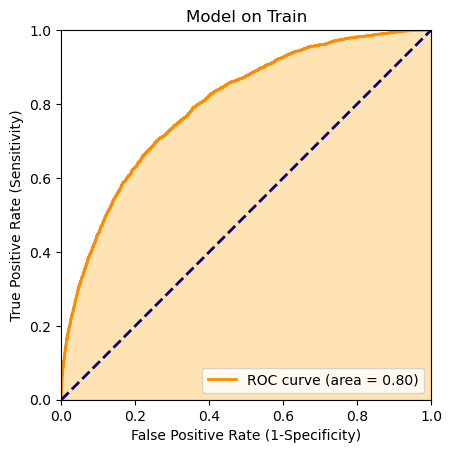

0.7969458034732366

In [29]:
pf_train = pandas.DataFrame({"churn":churn_train})
pf_train["pred"] = model.predict_proba(cross_sparse)[:, 1]
plot_roc(pf_train["pred"], pf_train["churn"], title="Model on Train")

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

<Figure size 640x480 with 0 Axes>

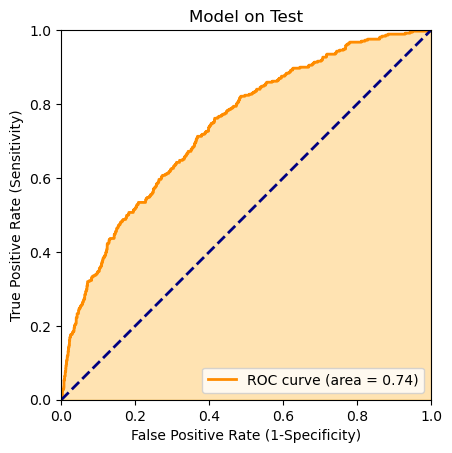

0.7375928920161583

In [30]:
test_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processed[[vi]]) for vi in model_vars])
pf = pandas.DataFrame({"churn":churn_test})
pf["pred"] = model.predict_proba(test_sparse)[:, 1]
plot_roc(pf["pred"], pf["churn"], title="Model on Test")

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution (link)](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

We can compare the above cross-frame solution to a naive "design transform and model on the same data set" solution as we show below.  Note we are leaveing filter to recommended on, to show the non-cross validated methodology still fails in an "easy case."

In [31]:
plan_naive = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,              
    params=vtreat.vtreat_parameters({'filter_to_recommended':True}))
plan_naive.fit(d_train, churn_train)
naive_frame = plan_naive.transform(d_train)


/Users/johnmount/Documents/work/pyvtreat/pkg/vtreat/vtreat_api.py:356: UserWarning: possibly called transform on same data used to fit
(this causes over-fit, please use fit_transform() instead)
  warnings.warn(


In [32]:
model_vars_naive = numpy.asarray(plan_naive.score_frame_["variable"][plan_naive.score_frame_["recommended"]])
len(model_vars_naive)

256

In [33]:
naive_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(naive_frame[[vi]]) for vi in model_vars_naive])

In [34]:
fd_naive = xgboost.DMatrix(data=naive_sparse, label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cvn = xgboost.cv(x_parameters, fd_naive, num_boost_round=100, verbose_eval=False)

In [35]:
bestn = cvn.loc[cvn["test-logloss-mean"] <= min(cvn["test-logloss-mean"] + 1.0e-9), :]
bestn

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
92,0.064519,0.000866,0.080306,0.000947


In [36]:
ntreen = bestn.index.values[0]
ntreen

92

In [37]:
fittern = xgboost.XGBClassifier(n_estimators=ntreen, max_depth=3, objective='binary:logistic')
fittern

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=92, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
modeln = fittern.fit(naive_sparse, churn_train)

In [39]:
test_processedn = plan_naive.transform(d_test)
test_processedn = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processedn[[vi]]) for vi in model_vars_naive])

<Figure size 640x480 with 0 Axes>

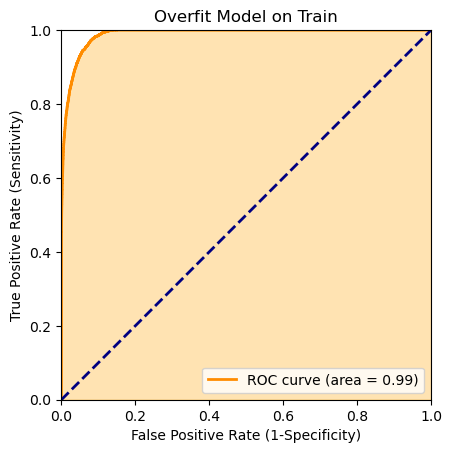

0.9887056900142546

In [40]:
pfn_train = pandas.DataFrame({"churn":churn_train})
pfn_train["pred_naive"] = modeln.predict_proba(naive_sparse)[:, 1]
plot_roc(pfn_train["pred_naive"], pfn_train["churn"], title="Overfit Model on Train")

<Figure size 640x480 with 0 Axes>

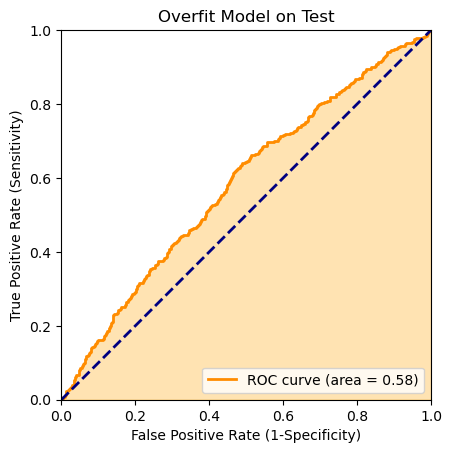

0.5838221154830853

In [41]:
pfn = pandas.DataFrame({"churn":churn_test})
pfn["pred_naive"] = modeln.predict_proba(test_processedn)[:, 1]
plot_roc(pfn["pred_naive"], pfn["churn"], title="Overfit Model on Test")

Note the naive test performance is worse, despite its far better training performance.  This is over-fit due to the nested model bias of using the same data to build the treatment plan and model without any cross-frame mitigations.


## Additional experiments

### data_algebra pipeline

In [42]:


transform_as_data = plan.description_matrix()

transform_as_data

,treatment_class,treatment,orig_var,orig_was_numeric,variable,value,replacement
0,IndicateMissingTransform,missing_indicator,Var172,True,Var172_is_bad,_NA_,1.000000
1,IndicateMissingTransform,missing_indicator,Var197,False,Var197_is_bad,_NA_,1.000000
2,IndicateMissingTransform,missing_indicator,Var122,True,Var122_is_bad,_NA_,1.000000
3,IndicateMissingTransform,missing_indicator,Var24,True,Var24_is_bad,_NA_,1.000000
4,IndicateMissingTransform,missing_indicator,Var34,True,Var34_is_bad,_NA_,1.000000
...,...,...,...,...,...,...,...
135839,MappedCodeTransform,prevalence_code,Var199,False,Var199_prevalence_code,zx8R9qL,0.000022
135840,MappedCodeTransform,prevalence_code,Var199,False,Var199_prevalence_code,zxagMIH,0.000022
135841,MappedCodeTransform,prevalence_code,Var199,False,Var199_prevalence_code,zxarPvc,0.000711
135842,MappedCodeTransform,prevalence_code,Var199,False,Var199_prevalence_code,zyR5BuUrkb8I9Lth,0.000067


In [43]:
incoming_vars = list(set(transform_as_data['orig_var']))

ops = vtreat.vtreat_db_adapter.as_data_algebra_pipeline(
    source=TableDescription(
        table_name='d_test',
        column_names=incoming_vars+ ['orig_index']),
    vtreat_descr=transform_as_data,
    treatment_table_name='transform_as_data',
    row_keys=['orig_index'],
)

test_by_pipeline = ops.eval({
    'd_test': d_test.loc[:, incoming_vars + ['orig_index']],
    'transform_as_data': transform_as_data})

In [44]:
assert test_by_pipeline.shape[0] == test_processed.shape[0]

In [45]:
assert test_by_pipeline.shape[1] >= test_processed.shape[1]

In [46]:
assert not numpy.any(numpy.isnan(test_by_pipeline))

In [47]:
test_pipeline_cols = set(test_by_pipeline.columns)
assert numpy.all([c in test_pipeline_cols for c in test_processed.columns])


In [48]:
test_cols_sorted = list(test_processed.columns)
test_cols_sorted.sort()
assert numpy.max(numpy.max(numpy.abs(test_processed[test_cols_sorted] - test_by_pipeline[test_cols_sorted]))) < 1e-5


### data algebra pipeline in database


In [49]:
db_handle = data_algebra.BigQuery.example_handle()

db_handle.drop_table('d_test_processed')
db_handle.insert_table(d_test.loc[:, incoming_vars + ['orig_index']], table_name='d_test', allow_overwrite=True)
_ = db_handle.insert_table(transform_as_data, table_name='transform_as_data', allow_overwrite=True)

/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [50]:
db_handle.execute(
    f"CREATE TABLE {db_handle.db_model.table_prefix}.d_test_processed AS {db_handle.to_sql(ops)}")

In [51]:
db_res = db_handle.read_query(
    f"SELECT * FROM {db_handle.db_model.table_prefix}.d_test_processed ORDER BY orig_index")

db_res

/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,Var172,Var122,Var24,Var34,Var111,Var139,Var145,Var25,Var100,Var16,...,Var206_prevalence_code,Var207_prevalence_code,Var208_prevalence_code,Var219_prevalence_code,Var227_prevalence_code,Var195_prevalence_code,Var221_prevalence_code,Var199_prevalence_code,Var200_prevalence_code,Var223_prevalence_code
0,9.646792,0.043049,4.486303,1.126457,281261.858241,177342.56,59.420168,0.000000,0.905751,120.735677,...,0.110400,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.002533,0.509111,0.732067
1,9.646792,0.043049,0.000000,1.126457,281261.858241,177342.56,59.420168,8.000000,0.905751,120.735677,...,0.128867,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.018067,0.509111,0.732067
2,9.646792,0.043049,0.000000,1.126457,281261.858241,177342.56,59.420168,0.000000,0.905751,120.735677,...,0.036044,0.701267,0.076533,0.807000,0.702733,0.959511,0.739733,0.015489,0.000000,0.732067
3,9.646792,0.043049,0.000000,1.126457,281261.858241,177342.56,59.420168,16.000000,0.905751,120.735677,...,0.128867,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.001156,0.509111,0.732067
4,9.646792,0.043049,10.000000,1.126457,281261.858241,177342.56,59.420168,80.000000,0.905751,120.735677,...,0.036044,0.138022,0.920644,0.005200,0.123333,0.959511,0.124333,0.002111,0.000022,0.732067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9.646792,0.043049,4.000000,1.126457,281261.858241,177342.56,59.420168,72.000000,0.905751,120.735677,...,0.128867,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.002489,0.509111,0.732067
4996,9.646792,0.043049,4.486303,1.126457,281261.858241,177342.56,59.420168,96.556955,7.000000,120.735677,...,0.110400,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.001000,0.509111,0.732067
4997,9.646792,0.043049,0.000000,1.126457,281261.858241,177342.56,59.420168,16.000000,0.905751,120.735677,...,0.055933,0.020956,0.920644,0.011133,0.046489,0.959511,0.033156,0.018067,0.000000,0.120778
4998,9.646792,0.043049,0.000000,1.126457,281261.858241,177342.56,59.420168,144.000000,0.905751,120.735677,...,0.128867,0.701267,0.920644,0.807000,0.702733,0.959511,0.739733,0.000089,0.509111,0.732067


In [52]:
assert db_res.shape[0] == test_processed.shape[0]

In [53]:
assert numpy.max(numpy.max(numpy.abs(test_processed[test_cols_sorted] - db_res[test_cols_sorted]))) < 1e-5


In [54]:
db_handle.drop_table('d_test')
db_handle.drop_table('transform_as_data')
db_handle.drop_table('d_test_processed')
db_handle.close()


/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/Users/johnmount/opt/anaconda3/envs/vtreat_dev_env/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
